##데이터 불러오기

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##라이브러리 불러오기

In [ ]:
import warnings
warnings.filterwarnings('ignore')

## Basic Import ##
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

## Tensorflow ## 
import tensorflow as tf #텐서플로우 딥러닝 관련 라이브러리
from tensorflow import keras #프레임워크 케라스
from keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array 
import sklearn as skl#사이킷런 머신러닝 관련 라이브러리
from sklearn.preprocessing import OneHotEncoder# 원핫인코더


from sklearn.metrics import accuracy_score # 대회 평가항목인 accuracy score

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Input, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping #early stopping. 일정 에폭동안 성능향상이 없으면 학습을 종료
from tensorflow.keras.experimental import CosineDecay #cosinedecay 학습을 진행할수록 cosine함수를 따라 LR을 조절합니다
from tensorflow.keras.applications import EfficientNetB1 #EfficientNetB1 모델을 사용합니다. (전이학습)
from tensorflow.keras.layers.experimental.preprocessing import CenterCrop, RandomRotation,RandomWidth,RandomHeight#전처리레이어로 데이터에 약간의 변화를 줍니다. overfitting을 방지할 수도 있으나 적용시 학습에 방해가 되었었습니다
from tensorflow.keras.optimizers import Adam #옵티마이저 Adam
from sklearn.model_selection import StratifiedKFold #StratifiedKFold
#import tensorflow_addons as tfa
#import tensorflow_addons.metrics.F1Score as F1score #F1Score를 통해 accuracy와 loss만으로 알기 힘든 정보를 알고자 했지만 적용실패. 모델에는 지장없습니다.

##데이터 압축 풀기

In [ ]:
!unzip /content/drive/MyDrive/cau_temp/data_numbers.zip

Archive:  /content/drive/MyDrive/cau_temp/data_numbers.zip
  inflating: submission.csv          
  inflating: test.csv                
  inflating: train.csv               


##데이터 읽기

In [ ]:
train=pd.read_csv('/content/train.csv').set_index('id')
test=pd.read_csv('/content/test.csv').set_index('id')
submission=pd.read_csv('/content/submission.csv')

In [ ]:
print(train.shape)#786개의 컬럼과 2048개의 train 데이터 

(2048, 786)


In [ ]:
submission.head() #submission파일을 확인합니다. id와 우리가 예측해야하는 숫자로 이루어져있습니다.

,id,digit
0,2049,0
1,2050,0
2,2051,0
3,2052,0
4,2053,0


In [ ]:
train.head()#train[0]은 숫자 train[1]은 문자 입니다. 여러 모델을 앙상블하면 문자에 대한 정보도 이용할 수 있을지 모르지만 기술적인 문제로 (28*28)의 grayscale 이미지데이터를 이용해 digit을 예측합니다

,digit,letter,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,...,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,5,L,1,1,1,4,3,0,0,4,4,3,0,4,3,3,3,4,4,0,0,1,1,3,4,0,4,2,0,4,0,1,3,1,0,4,1,1,3,1,...,4,3,4,1,3,0,0,1,3,3,3,0,3,2,2,1,0,1,0,0,3,0,0,4,2,0,3,4,1,1,2,1,0,1,2,4,4,4,3,4
2,0,B,0,4,0,0,4,1,1,1,4,2,0,3,4,0,0,2,3,4,0,3,4,3,0,2,2,1,4,2,3,3,4,1,2,4,2,0,3,2,...,4,2,3,0,0,0,0,4,3,2,2,4,2,1,1,1,3,3,1,2,4,4,4,2,2,4,4,0,4,2,0,3,0,1,4,1,4,2,1,2
3,4,L,1,1,2,2,1,1,1,0,2,1,3,2,2,2,4,1,1,4,1,0,1,3,4,2,2,2,4,1,1,2,0,3,0,2,3,4,0,1,...,3,0,4,0,3,0,2,0,1,4,2,3,4,4,4,0,2,0,4,4,1,3,0,3,2,0,2,3,0,2,3,3,3,0,2,0,3,0,2,2
4,9,D,1,2,0,2,0,4,0,3,4,3,1,0,3,2,2,0,3,4,1,0,4,1,2,2,3,2,2,0,2,0,3,0,3,2,4,0,0,4,...,0,3,0,1,4,1,3,1,2,1,1,1,2,2,2,4,3,4,3,0,4,1,2,4,1,4,0,1,0,4,3,3,2,0,1,4,0,0,1,1
5,6,A,3,0,2,4,0,3,0,4,2,4,2,1,4,1,1,4,4,0,2,3,4,4,3,3,3,3,4,1,0,3,0,3,0,0,0,1,1,2,...,2,1,3,2,1,4,2,3,2,2,1,0,4,2,2,1,2,1,0,3,2,2,2,2,1,4,2,1,2,1,4,4,3,2,1,3,4,3,1,2


In [ ]:
train['letter'].value_counts() # train 데이터의 문자별 데이터 개수를 확인합니다 많으면 91 적으면 64로 balanced data라고 할 수 있습니다.

Z    91
K    90
O    90
H    89
L    89
G    87
M    86
Y    86
U    85
T    82
Q    82
R    81
F    80
X    79
N    77
D    76
S    76
C    74
V    73
A    72
B    71
W    69
J    67
E    66
P    66
I    64
Name: letter, dtype: int64

In [ ]:
train['digit'].value_counts() # train 데이터의 숫자별 데이터 개수를 확인합니다. 많으면 233 적으면 182로 이 역시 balenced data입니다

2    233
5    225
6    212
4    207
3    205
1    202
9    197
7    194
0    191
8    182
Name: digit, dtype: int64

In [ ]:
test #test 데이터는 id가 2049부터 20480 train set의 10배를 예측해야하고 letter와 28*28의 이미지 정보가 있습니다

,letter,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2049,L,0,4,0,2,4,2,3,1,0,0,1,0,1,3,4,4,0,0,2,4,4,1,3,3,2,2,4,1,0,1,2,2,1,2,2,1,4,0,4,...,1,3,1,1,3,3,4,1,3,1,2,4,1,2,0,3,1,2,4,0,2,1,2,4,1,1,3,2,1,0,2,0,4,2,2,4,3,4,1,4
2050,C,4,1,4,0,1,1,0,2,2,1,0,3,0,1,1,4,1,2,0,2,2,0,4,3,4,0,2,4,4,2,1,2,4,0,4,2,0,2,3,...,3,4,2,6,2,2,0,1,2,4,1,1,3,3,2,3,4,2,2,4,3,1,3,3,3,1,3,4,4,2,0,3,2,4,2,4,2,2,1,2
2051,S,0,4,0,1,3,2,3,0,2,1,2,0,1,0,3,0,1,4,3,0,0,3,0,4,1,0,3,2,0,4,1,2,0,0,1,3,0,2,1,...,0,4,4,3,4,1,4,2,3,4,1,2,0,2,2,3,3,1,1,4,1,2,4,0,0,0,0,2,3,2,1,3,2,0,3,2,3,0,1,4
2052,K,2,1,3,3,3,4,3,0,0,2,3,2,3,4,4,4,0,1,4,2,2,0,1,4,3,1,3,0,2,3,2,4,3,1,1,4,0,0,3,...,0,4,1,1,2,3,2,3,3,0,0,1,3,3,0,2,0,0,2,3,2,2,3,1,1,2,4,0,1,2,3,0,3,2,4,1,0,4,4,4
2053,W,1,0,1,1,2,2,1,4,1,1,4,3,4,1,2,1,4,3,3,4,0,4,4,2,0,0,0,0,3,4,0,1,4,2,2,2,1,4,4,...,4,1,3,2,1,2,1,4,4,1,2,3,2,4,2,1,4,3,4,3,0,1,0,1,1,2,1,1,0,2,4,3,1,4,0,2,1,2,3,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22524,P,1,2,1,1,0,0,0,2,1,0,0,2,4,3,2,0,1,3,1,1,0,2,0,4,4,2,3,0,2,2,2,2,1,3,2,2,4,1,0,...,1,4,4,2,1,3,4,2,3,2,4,2,3,1,1,3,2,4,3,1,2,1,3,0,4,2,2,1,1,4,0,1,3,0,3,0,4,3,1,4
22525,S,4,1,1,4,0,0,1,1,4,3,2,3,3,2,2,0,0,0,2,4,3,0,2,0,2,4,2,3,3,1,4,2,2,3,2,2,2,0,0,...,1,1,0,2,1,4,4,4,0,1,2,4,4,4,1,2,4,2,1,4,1,0,1,0,4,2,0,0,3,4,1,3,1,0,0,1,3,1,2,0
22526,B,4,2,1,3,2,1,3,0,4,4,1,0,0,1,2,1,2,2,0,3,0,4,0,2,3,3,4,1,2,0,1,2,4,3,1,3,3,1,1,...,1,3,3,2,1,3,0,3,2,3,2,4,2,0,4,2,2,2,1,1,0,3,0,2,1,4,3,2,3,4,3,2,3,4,1,0,3,3,1,1


##데이터 Reshape and normalization 

In [ ]:
x_train=train.iloc[:,2:]  #train데이터의 3번째 컬럼 이후 모든 컬럼, 0~783픽셀에 해당하는 값을 받아옵니다.
y_train=train.digit       #train의 숫자를 받아옵니다. 
x_test=test.iloc[:,1:]    #test 데이터 또한 0~783픽셀의 값들을 받아옵니다

In [ ]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255   #normalization

In [ ]:
x_train=x_train.values.reshape(-1,28,28,1)
x_test=x_test.values.reshape(-1,28,28,1)    #train과 test의 x를 이미지의 형태로 reshape해줍니다

x_train.shape, x_test.shape     #각각 2048개 20480개의 데이터가 28*28로 나타났습니다

((2048, 28, 28, 1), (20480, 28, 28, 1))

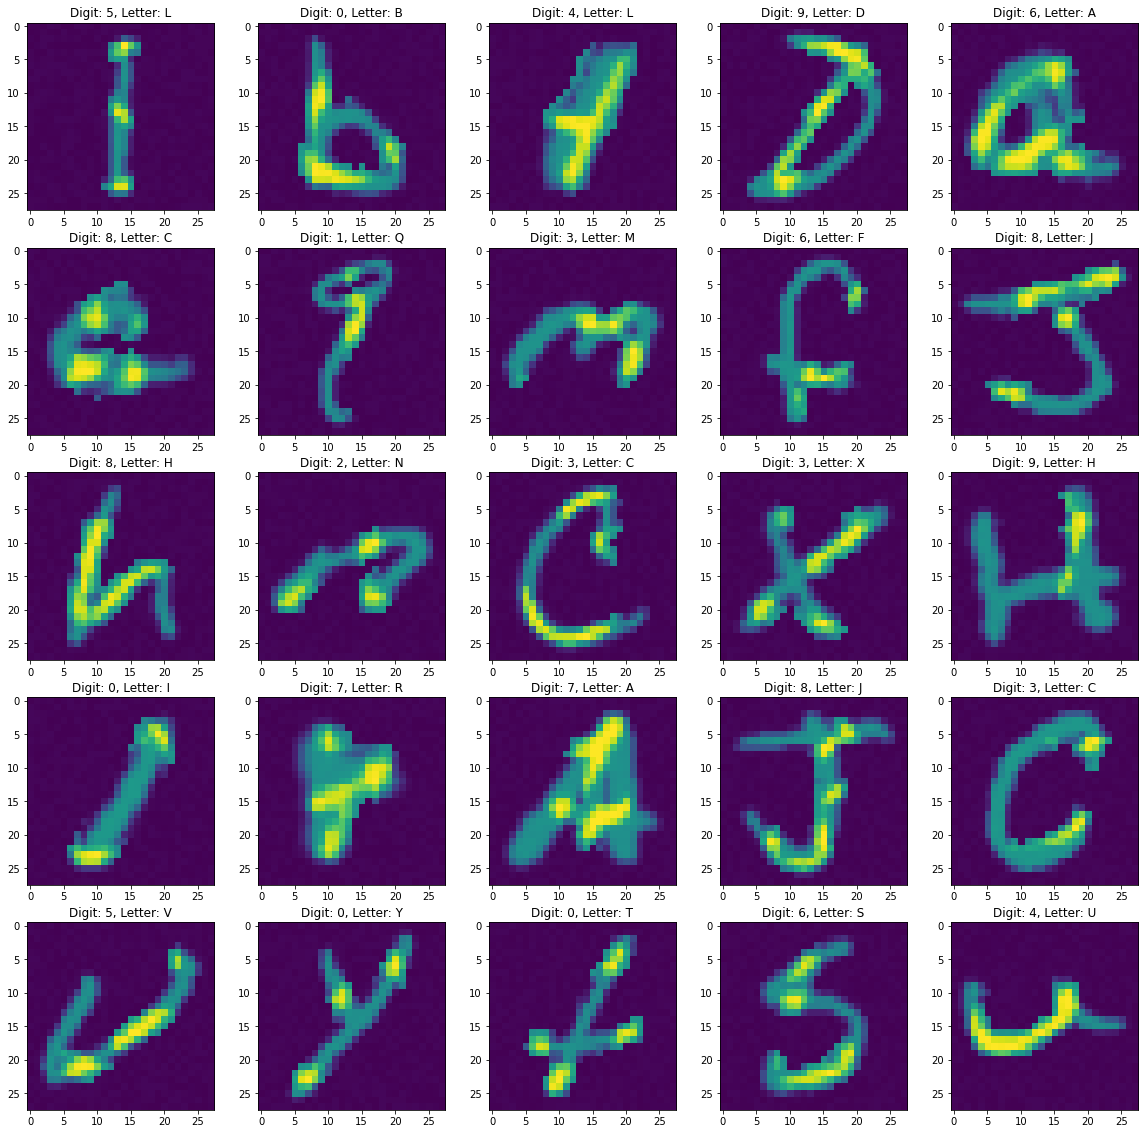

In [ ]:
#데이터 확인
plt.figure(figsize=(20,20))
for i in range(25):
    img = x_train[i].reshape(28,28)
    digit = train.loc[i+1, 'digit']
    letter = train.loc[i+1, 'letter']
    plt.subplot(5,5, i + 1)
    plt.title('Digit: %s, Letter: %s'%(digit, letter))
    plt.imshow(img)       #숫자를 문자모양의 구멍으로 들여다 보듯 이미지가 나타나 있습니다.

##Callback 과 Cosine decay

In [ ]:
# copy from https://gist.github.com/stared/dfb4dfaf6d9a8501cd1cc8b8cb806d2e
from IPython.display import clear_output
from tensorflow.keras.callbacks import Callback

class PlotLosses(Callback):
  def on_train_begin(self, logs={}):

    self.i = 0
    self.x = []
    self.losses = []
    self.val_losses = []
    self.fig = plt.figure()
    self.logs = []

  def on_epoch_end(self, epoch, logs={}):

    self.logs.append(logs)
    self.x.append(self.i)
    self.losses.append(logs.get('loss'))
    self.val_losses.append(logs.get('val_loss'))
    self.i += 1

    clear_output(wait=True)
    plt.plot(self.x, self.losses, label="loss")
    plt.plot(self.x, self.val_losses, label="val_loss")
    plt.title('FOLD %i'%
                (fold+1),size=18)
    plt.legend()
    plt.show();
    print("loss = ", self.losses[-1], ", val_loss = ", self.val_losses[-1])

plot_losses = PlotLosses()    #Callback으로 에폭마다 loss를 출력하는 함수
CALLBACKS=[plot_losses, EarlyStopping(monitor='accuracy', patience = 50, verbose=0)]#현재 int(patience)epoch동안 val_loss증가 안하면 학습 중지

In [ ]:
#parameters
BATCHSIZE=32          #Batchsize 설정.(파라미터 업데이트할 때 얼마나 데이터를 쓰는지)
EPOCH=100           #EPOCH설정, earlystopping이 적용되긴하지만 적절히 설정 사실 1000도 클지도
INITIAL_LR=1e-3       #초기 LearningRate. 이후 Cosine_Decay 할 예정
dropout_rate=0.3      #모델에 있는 dropout layer의 dropout rate를 조절합니다 오버피팅을 방지합니다

N_KFOLD=5 
DECAYSTEP = int(round((2048*(N_KFOLD-1)/N_KFOLD)/BATCHSIZE))*EPOCH  
#cosinedecay의 decaystep을 설정합니다 이 식을 따르면 earlystopping없이 모든 학습이 진행될 즈음 최소 학습률에 도달합니다 
cosine_decay = CosineDecay(initial_learning_rate=INITIAL_LR, decay_steps=DECAYSTEP, alpha=0.05) 
#Cosine함수를 따라 LR조절. alpha*초기학습률은 최소 학습률을 의미합니다.

##EfficientnetB1 사용 위한 데이터 전처리

In [ ]:
#preprocessing 데이터 전처리
#efficientnetb0를 사용하고 imagenet weight를 활용하기 위해 32*32이상의 RGB이미지로 변형해주어야합니다
import cv2 #이미지 처리를 위한 cv2라이브러리를 import합니다
x_train1 = np.full((2048, 28, 28, 3), 0.0)
x_train3 = np.full((2048, 56, 56, 3), 0.0)  #변형된 데이터들을 담을 이미지를 모아줍니다 56는 28*2로 픽셀값들이 최대한 손상이 안가게 하고자 했습니다 

for i, s in enumerate(x_train):   #enumerate는 인덱스와 원소(여기선 인덱스에 해당하는 이미지)로 이루어진 tuple을 반환합니다
    x_train1[i] = cv2.cvtColor(s, cv2.COLOR_GRAY2RGB) #i에 해당하는 이미지를 RGB로 변환하여 저장합니다
    x_train3[i] = cv2.resize(x_train1[i],(56,56),interpolation = cv2.INTER_CUBIC)   #28*28*3을 56*56*3으로 부풀립니다

x_train2=x_train3.reshape((2048, 56, 56, 3))   #과정을 거친 데이터를 x_train2로 담아줍니다. 총 2048개의 56*56*3의 x_train을 얻었습니다

x_test1 = np.full((20480, 28, 28, 3), 0.0)
x_test3 = np.full((20480, 56, 56, 3), 0.0)    #test 데이터도 같은 과정을 거쳐줍니다

for i, s in enumerate(x_test):
    x_test1[i] = cv2.cvtColor(s, cv2.COLOR_GRAY2RGB)
    x_test3[i] = cv2.resize(x_test1[i],(56,56),interpolation = cv2.INTER_CUBIC)

x_test2=x_test3.reshape((20480, 56, 56, 3))# effnet weight를 받아오기 위해 RGB, 32*32이상으로 이미지를 변환함

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


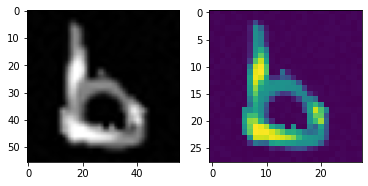

In [ ]:

plt.subplot(1,2, 1)
g = plt.imshow(x_train2[1])

plt.subplot(1,2, 2)
z = plt.imshow(x_train[1].reshape(28,28))
 #왼쪽은 처리 후 이미지 오른쪽은 처리 전 이미지 입니다

##one hot encoding

In [ ]:
target = y_train

num = np.unique(target, axis=0)
num = num.shape[0]  #target value의 개수를 확인합니다 0~9까지 10의 값이 들어가 있을 것입니다


y_train4 = np.eye(num)[target] #eye는 num*num의 단위행렬을 만들고 target에 해당하는 값을 가져옵니다. 즉 OneHotencoding됩니다
y_train4

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

##모델 정의하기

In [ ]:
efficientnet = EfficientNetB1(weights="imagenet",      #이미지넷 가중치 값을 불러와 적용
                              include_top=False,        #네트워크 상단에 fully-connected layer를 포함할지 여부.
                              input_shape=(56,56,3),    
                              drop_connect_rate=0.3     #dropout얼마나할지
                              )   #efficientnetB0 모델을 로드
efficientnet.trainable=True # efficientnetb0의 학습을 허용

27033600/27018416 [==============================] - 0s 0us/step


In [ ]:
data_augmentation_layers = tf.keras.Sequential(
    [
        layers.experimental.preprocessing.RandomRotation(0.1), #이미지를 좌우로 10% 이내로 랜덤으로 돌립니다. 
        layers.experimental.preprocessing.RandomZoom((-0.05, 0.05)), #이미지를 -5~5%만큼 랜덤으로 zoom합니다.
        layers.RandomWidth((0,0.05)), #이미지를 0~5%만큼 너비를 zoom합니다.
        layers.RandomHeight((0,0.05)) #이미지를 0~5%만큼 높이를 zoom합니다.
    ]
)

In [ ]:
#model
model = Sequential() #새 Sequential 모델을 만듬 
model.add(Input(shape=(56,56,3))) #인풋을 이미지 사이즈로 설정
model.add(data_augmentation_layers) #이미지 augumentation 레이어 추가
model.add(efficientnet)           # efficientnetb1 추가
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(layers.GlobalAveragePooling2D()) # 풀링 레이어를 추가
model.add(layers.Dropout(dropout_rate)) # 드롭아웃 레이어를 추가
model.add(Dense(10, activation="softmax")) #마지막 덴스 레이어를 추가. 예측할 클래스의 개수만큼이 아웃풋이 된다. 
model.summary() #모델 확인

model.compile(optimizer=Adam(cosine_decay), #cosine_decay를 적용한 optimizer Adam
              loss="categorical_crossentropy", #loss는 onehot으로 인코딩하여 categorical_crossentropy를 이용합니다
              metrics=["accuracy"]  #대회 평가 항목이 accuracy이므로 함께 확인합니다
              )

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb1 (Functional)  (None, 2, 2, 1280)        6575239   
_________________________________________________________________
dense_5 (Dense)              (None, 2, 2, 128)         163968    
_________________________________________________________________
batch_normalization_2 (Batch (None, 2, 2, 128)         512       
_________________________________________________________________
dense_6 (Dense)              (None, 2, 2, 64)          8256      
_________________________________________________________________
batch_normalization_3 (Batch (None, 2, 2, 64)          256       
_________________________________________________________________
global_average_pooling2d_3 ( (None, 64)               

In [ ]:
results = np.zeros((20480,10),dtype=np.float32) #y_test 크기의 array를 만들어 줍니다

#각 fold마다 예측한 값을 바탕으로 soft voting을 적용하기 위함입니다
#soft voting은 앙상블 기법 중 하나로 여러 모델이 예측한 각 숫자들의 확률을 모두 더한 후 가장 확률이 높은 값을 내놓습니다  


##StratifieldKfold 사용한 교차검증과 이를 바탕으로 한 Soft Voting

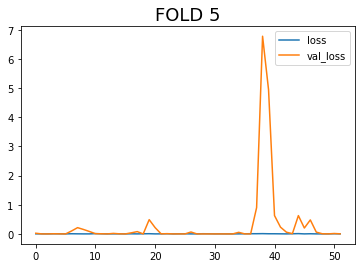

loss =  0.0015817228704690933 , val_loss =  0.003638897091150284


In [ ]:
from sklearn.metrics import accuracy_score
kf = StratifiedKFold(n_splits = N_KFOLD , shuffle = True , random_state = 138)  #교차검증을 위한 stratifiedKfold

acc=[0,0,0,0,0]
for fold, (tr , va) in enumerate(kf.split(x_train2 , y_train.values)) : #fold에 따라 train, validation set을 나누어 학습시킵니다 

  train_x,test_x = x_train2[tr] , x_train2[va]
  train_y, test_y = y_train4[tr] , y_train4[va]

  model.fit(train_x,train_y,
            verbose=0,
            batch_size=BATCHSIZE,
            epochs=EPOCH,
            callbacks=CALLBACKS,
            validation_data=(test_x,test_y)
            )
  val_preds=np.eye(num)[np.argmax(model.predict(test_x),axis=1)]
  acc[fold]=accuracy_score(test_y, val_preds) #validation set을 예측하여 잘 학습했는지 accuracy로 확인합니다

  results = results + model.predict(x_test2)  #fold마다 학습된 모델이 test셋이 어떤 숫자일지 확률을 예측하여 더해줍니다
  
 
 
    

fold 당 validation_accuracy 출력과 submission file 제출

In [ ]:
for i in range(N_KFOLD):
  print('acc at fold',i,' : ',acc[i])
  print("-----------------------------------------------")

acc at fold 0  :  1.0
-----------------------------------------------
acc at fold 1  :  0.9878048780487805
-----------------------------------------------
acc at fold 2  :  1.0
-----------------------------------------------
acc at fold 3  :  0.9755501222493888
-----------------------------------------------
acc at fold 4  :  1.0
-----------------------------------------------


In [ ]:
submission['digit'] = np.argmax(results, axis=1)  #확률이 가장 큰 값을 submission의 digit column에 넣어줍니다
# model.predict(x_test)
submission.head()
submission.to_csv('/content/drive/MyDrive/Colab Notebooks/loadtest4.csv', index=False)  #예측한 값들을 csv파일로 뱉어냅니다